In [9]:
%matplotlib notebook
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns

import linear_cca
import multimodal_data

In [182]:
# ccMat2=pd.read_pickle("../../results/cpFeaturesGene_ccMat.pkl")
# ccMat2

In [3]:
dataDir="../../collated/"
# # meta = pd.read_fwf("../../metadata/affy_probe_gene_mapping.txt")
# meta=pd.read_csv("../../metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
# meta=meta.set_index('probe_id')
# meta.head()


In [154]:
# meta.loc['201000_at',:]

In [158]:
# genes4probes=meta.loc[ccMat.index,'gene'].tolist()


In [159]:
# ccMat.index=genes4probes

In [162]:
# ccMat.to_pickle("../../results/cpFeaturesGene_ccMat.pkl")

### Load Data - old

In [4]:
dataDir="../../collated/"
l1k0 = pd.read_csv(dataDir+"TAOE014015_L1000/replicate_level_all_alleles2.csv")
l1k1=l1k0.iloc[:,:-1]
l1k1.index=l1k0.allele;
# l1k1.head()
cp0 = pd.read_csv(dataDir+"TAOE014015_CellPainting_Resnet/morphology.csv")
fnamesCP=cp0.columns[cp0.columns.str.contains("Cells|Cytoplasm|Nuclei")];
cp1=cp0[fnamesCP];
cp1.index=cp0.Allele;
cp1=cp1[~cp1.index.isnull()]
# cp1.head()
common_alleles2 = list(set(cp1.index.unique()).intersection( l1k1.index.unique()))
common_alleles3 = [x for x in common_alleles2 if x not in ["EGFP", "BFP", "HCRED"]]

l1k_rep = l1k1.loc[common_alleles3,:]
cp_rep = cp1.loc[common_alleles3,:]

cp_tr=cp_rep.groupby('Allele').mean()
l1k_tr=l1k_rep.groupby('allele').mean()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
# l1k_rep.head()
# cp_rep.head()
# len(common_alleles3)
# l1k_tr.head()
# cp_tr.head()

In [64]:
# cp_tr.head()

In [172]:
np.power(2,16)

65536

In [99]:
lmVec=l1k_tr['218581_at'].values
# lmVec
scipy.stats.pearsonr(lmVec, cp_tr['Cells_AreaShape_Compactness'])[0]

-0.06567477121513426

In [ ]:
# ccMat.columns[ccMat.isnull().sum(axis=0)!=0]
# ccMat.index[ccMat.isnull().sum(axis=1)!=0]
ccMat.dtypes

In [122]:
ccMat=ccMat.astype('float')

### Cross-Correlation of each feature with each landmark gene vector - Treatment level

In [83]:
ccMat=pd.DataFrame(index=l1k_tr.columns,columns=cp_tr.columns,dtype=float)
for i in range(ccMat.shape[0]):
# i=0
    lm=ccMat.index[i];
    lmVec=l1k_tr[lm].values;
    # cpMat=cp_tr.values;
    for j in range(ccMat.shape[1]):
        cpfeatName=ccMat.columns[j];
        ccMat.loc[lm,cpfeatName]=scipy.stats.pearsonr(lmVec, cp_tr[cpfeatName].values)[0]
        
ccMat.to_pickle("../../results/cpFeaturesGene_ccMat.pkl")
ccMat.to_csv("../../results/cpFeaturesGene_ccMat.csv")

In [205]:
# Standardize or Normalize every column in the figure
# Standardize:

# g=sns.clustermap(ccMat, standard_scale=1,xticklabels=1,yticklabels=1,figsize=(50,160))
g=sns.clustermap(ccMat,xticklabels=1,yticklabels=1,cmap="coolwarm",figsize=(50,160))
g.savefig('../../results/cpFeaturesGene_ccMat.png', format='png',dpi=100)
# Normalize
# sns.clustermap(ccMat, z_score=1)

### GLM of all features and each landmark gene vector - Treatment level

In [228]:
# using GLM for each replicate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
glmMat=pd.DataFrame(index=l1k_tr.columns,columns=cp_tr.columns,dtype=float)
error=[]
sc = sklearn.preprocessing.StandardScaler()  
cpMat=sc.fit_transform(cp_tr);
for i in range(glmMat.shape[0]):
# i=6
    lm=glmMat.index[i];
    lmVec=l1k_tr[lm].values;
    # cpMat=cp_tr.values;
      
    reg = LinearRegression().fit(cpMat, lmVec)
    lmVecPred=reg.predict(cpMat)
    er=mean_squared_error(lmVec, lmVecPred)
    error.append(er)
    glmMat.loc[lm,:]=reg.coef_
    
glmMat.index=genes4probes    
glmMat.to_pickle("../../results/cpFeaturesGene_glmMat.pkl")
glmMat.to_csv("../../results/cpFeaturesGene_glmMat.csv")

In [207]:
print(np.min(error), np.max(error),np.median(error))

8.665252234372044e-30 1.4111828855891759e-27 5.31634823674852e-29


In [230]:
g=sns.clustermap(glmMat,standard_scale=0,xticklabels=1,yticklabels=1,cmap="coolwarm",figsize=(50,160))
g.savefig('../../results/cpFeaturesGene_glmMat.png', format='png',dpi=100)

### MI of all features and each landmark gene vector - Treatment level

In [222]:
# using MI between each feature and lanmark gene
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
miMat=pd.DataFrame(index=l1k_tr.columns,columns=cp_tr.columns,dtype=float)
error=[]
sc = sklearn.preprocessing.StandardScaler()  
cpMat=sc.fit_transform(cp_tr);
for i in range(miMat.shape[0]):
# i=6
    lm=miMat.index[i];
    lmVec=l1k_tr[lm].values;
    # cpMat=cp_tr.values;

    mi = mutual_info_regression(cpMat, lmVec)
    mi /= np.max(mi)
#     er=mean_squared_error(lmVec, lmVecPred)
#     error.append(er)
    miMat.loc[lm,:]=mi
    
miMat.index=genes4probes      
miMat.to_pickle("../../results/cpFeaturesGene_miMat.pkl")
miMat.to_csv("../../results/cpFeaturesGene_miMat.csv")

In [227]:
g=sns.clustermap(miMat,xticklabels=1,yticklabels=1,cmap="coolwarm",figsize=(50,160))
g.savefig('../../results/cpFeaturesGene_miMat.png', format='png',dpi=100)

In [225]:
miMat.max(axis=1)

AARS                    1.0
ABCB6                   1.0
ABCC5                   1.0
ABCF1                   1.0
ABCF3                   1.0
ABHD4                   1.0
ABHD6///LOC643635       1.0
ABL1                    1.0
ACAA1                   1.0
ACAT2                   1.0
ACBD3                   1.0
ACD                     1.0
ACLY                    1.0
ACOT9                   1.0
ADAM10                  1.0
ADAT1                   1.0
CABC1                   1.0
ADH5                    1.0
ADI1                    1.0
ADO                     1.0
ADRB2                   1.0
AGL                     1.0
AKAP8                   1.0
AKAP8L                  1.0
AKR7A2                  1.0
AKT1                    1.0
ALAS1                   1.0
ALDH7A1                 1.0
ALDOA                   1.0
ALDOC                   1.0
                       ... 
LOC100133724///VDAC1    1.0
VGLL4                   1.0
VPS28                   1.0
VPS72                   1.0
WASF3               

<IPython.core.display.Javascript object>


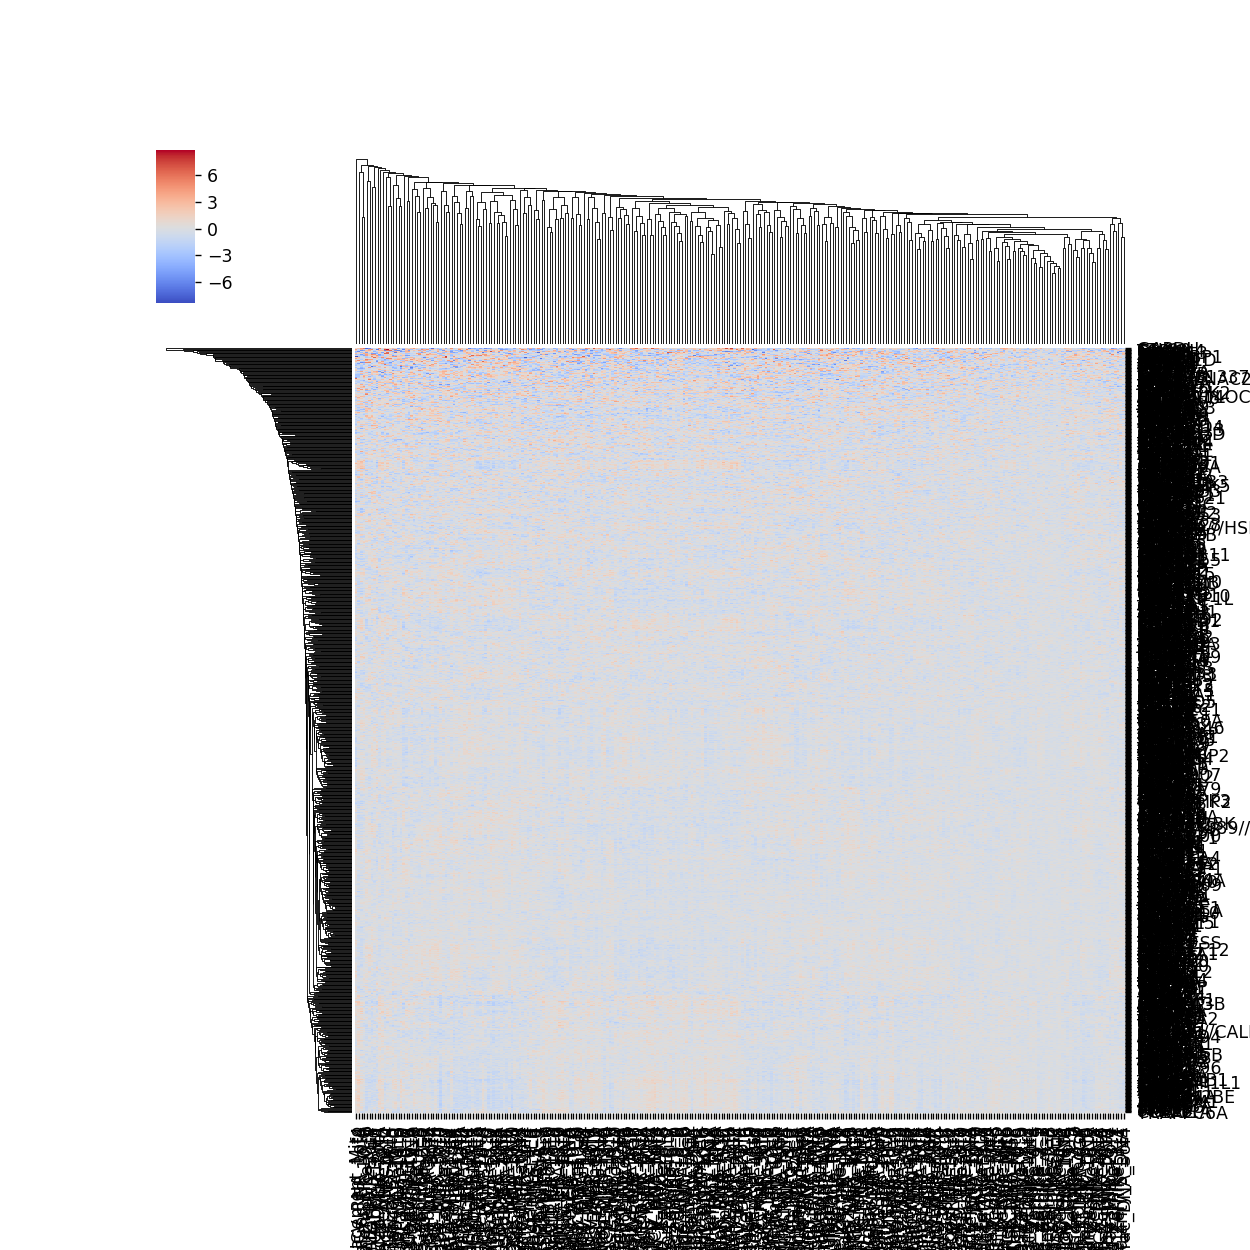

In [25]:
# ccMat=pd.read_pickle("../../results/cpFeaturesGene_ccMat.pkl")
miMat=pd.read_pickle("../../results/cpFeaturesGene_glmMat.pkl")
clustergrid=sns.clustermap(miMat,xticklabels=1,yticklabels=1,cmap="coolwarm")
miMat2=miMat.iloc[clustergrid.dendrogram_row.reordered_ind,clustergrid.dendrogram_col.reordered_ind]
miMat2.to_csv("../../results/cpFeaturesGene_glmMat.csv")


In [19]:
# ccMat=pd.read_pickle("../../results/cpFeaturesGene_ccMat.pkl")
miMat=pd.read_pickle("../../results/cpFeaturesGene_miMat.pkl")
# from scipy.cluster.hierarchy import dendrogram, linkage
# Z = linkage(ccMat, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
# plt.show()
clustergrid=sns.clustermap(miMat,xticklabels=1,yticklabels=1,cmap="coolwarm")
ccMat2=miMat.iloc[clustergrid.dendrogram_row.reordered_ind,clustergrid.dendrogram_col.reordered_ind]


<IPython.core.display.Javascript object>

KeyError: KeyError("None of [Int64Index([418, 706, 216, 415, 416, 348, 485, 897, 300, 515,\n            ...\n            636, 166,  78, 570, 396,  21, 535, 632,  46, 608],\n           dtype='int64', length=978)] are in the [index]",)

In [12]:
clustergrid.dendrogram_row.reordered_ind;

In [13]:
clustergrid.dendrogram_column.reordered_ind;

AttributeError: 'ClusterGrid' object has no attribute 'dendrogram_column'

In [20]:
ccMat2=ccMat.iloc[clustergrid.dendrogram_row.reordered_ind,clustergrid.dendrogram_col.reordered_ind]

<IPython.core.display.Javascript object>


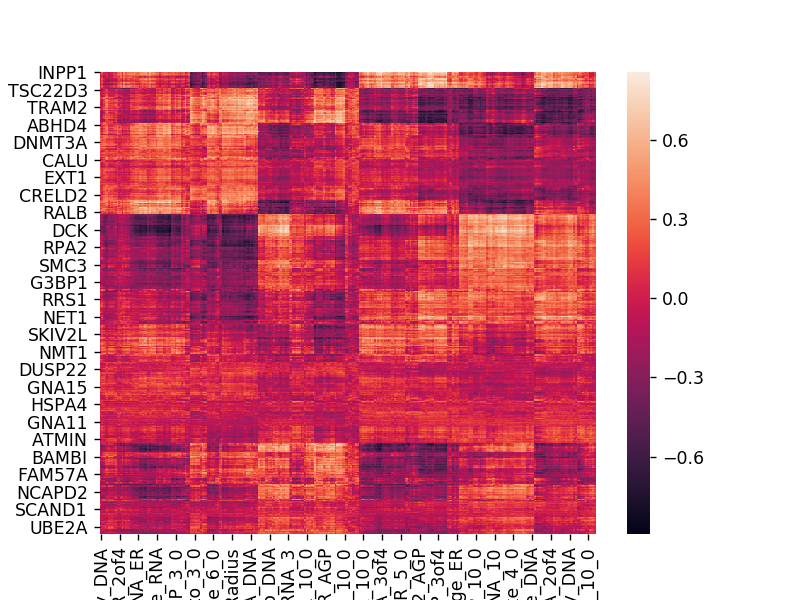

In [22]:
plt.figure()
sns.heatmap(ccMat2)